# DDPG Hyperparameter Sweep Analysis

This notebook provides a professional, reproducible analysis of hyperparameter sweep results for the DDPG (Deep Deterministic Policy Gradient) algorithm. It loads, aggregates, and visualizes experiment results to facilitate research insights and comparison.

**Contents:**
1. Import Required Libraries
2. Load and Aggregate Results
3. Display Summary Table
4. Plot All Learning Curves
5. Plot Critic/Actor Loss Curves

---

*For details on experiment setup, see the project [README](../README.md) and [architecture documentation](../docs/architecture.md).*

In [3]:
# 1. Import Required Libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plotting style
sns.set(style="darkgrid", font_scale=1.2)
%matplotlib inline

In [4]:
# 2. Load and Aggregate Results

def parse_hyperparams_from_filename(filename):
    """Extract hyperparameters from result filename."""
    import re
    pattern = r"pendulum_tau([\d.e-]+)_bs(\d+)_alpha([\d.e-]+)_beta([\d.e-]+)_l(\d+)_([\d]+)_?([a-zA-Z0-9]*)"
    match = re.search(pattern, filename)
    if match:
        tau, bs, alpha, beta, layers, timestamp, extra = match.groups()
        return {
            'tau': float(tau),
            'batch_size': int(bs),
            'alpha': float(alpha),
            'beta': float(beta),
            'layers': int(layers),
            'timestamp': timestamp,
            'extra': extra
        }
    return {}

# Find all score files
results_dir = Path('../results') if not Path('results').exists() else Path('results')
score_files = sorted(results_dir.glob('pendulum*_scores.npy'))

# Aggregate results
results = []
for score_file in score_files:
    params = parse_hyperparams_from_filename(score_file.name)
    scores = np.load(score_file)
    params['mean_score'] = np.mean(scores[-100:])  # mean of last 100 episodes
    params['max_score'] = np.max(scores)
    params['min_score'] = np.min(scores)
    params['final_score'] = scores[-1]
    params['scores'] = scores
    # Try to find corresponding loss file
    loss_file = score_file.with_name(score_file.name.replace('_scores.npy', '_losses.npy'))
    if loss_file.exists():
        losses = np.load(loss_file, allow_pickle=True).item()
        params['actor_losses'] = losses.get('actor')
        params['critic_losses'] = losses.get('critic')
    results.append(params)

# Convert to DataFrame for summary
results_df = pd.DataFrame(results)
print(f"Loaded {len(results_df)} runs.")

Loaded 12 runs.


In [5]:
# 3. Display Summary Table

# Show key columns for quick comparison
summary_cols = ['tau', 'batch_size', 'alpha', 'beta', 'layers', 'mean_score', 'final_score', 'max_score', 'min_score', 'timestamp']
display(results_df[summary_cols].sort_values(by='mean_score', ascending=False).reset_index(drop=True))

,tau,batch_size,alpha,beta,layers,mean_score,final_score,max_score,min_score,timestamp
0,0.001,32,0.00005,0.0005,1400,-1295.582066,-1799.067492,-630.004748,-1942.558561,20250703
1,0.001,32,0.00010,0.0005,1800,-1296.724420,-1797.235671,-623.791215,-1939.107294,20250704
2,0.001,32,0.00005,0.0010,1800,-1300.267646,-1799.861837,-613.831686,-1902.274943,20250703
3,0.001,32,0.00005,0.0005,1800,-1301.676027,-1725.148885,-626.630256,-1939.196346,20250703
4,0.001,32,0.00005,0.0010,1200,-1305.055320,-1802.753420,-643.160441,-1935.607183,20250703
5,0.001,32,0.00010,0.0005,1400,-1308.157894,-1798.234453,-628.634918,-1941.003189,20250704
6,0.001,32,0.00010,0.0005,1200,-1309.753053,-1802.117036,-743.767637,-1919.298316,20250704
7,0.001,32,0.00005,0.0020,1800,-1310.358821,-1787.213450,-636.284963,-1936.274981,20250704
8,0.001,32,0.00005,0.0005,1200,-1313.101839,-1793.950100,-740.844725,-1909.542840,20250703
9,0.001,32,0.00005,0.0020,1200,-1330.681774,-1790.178782,-665.732617,-1913.000815,20250703


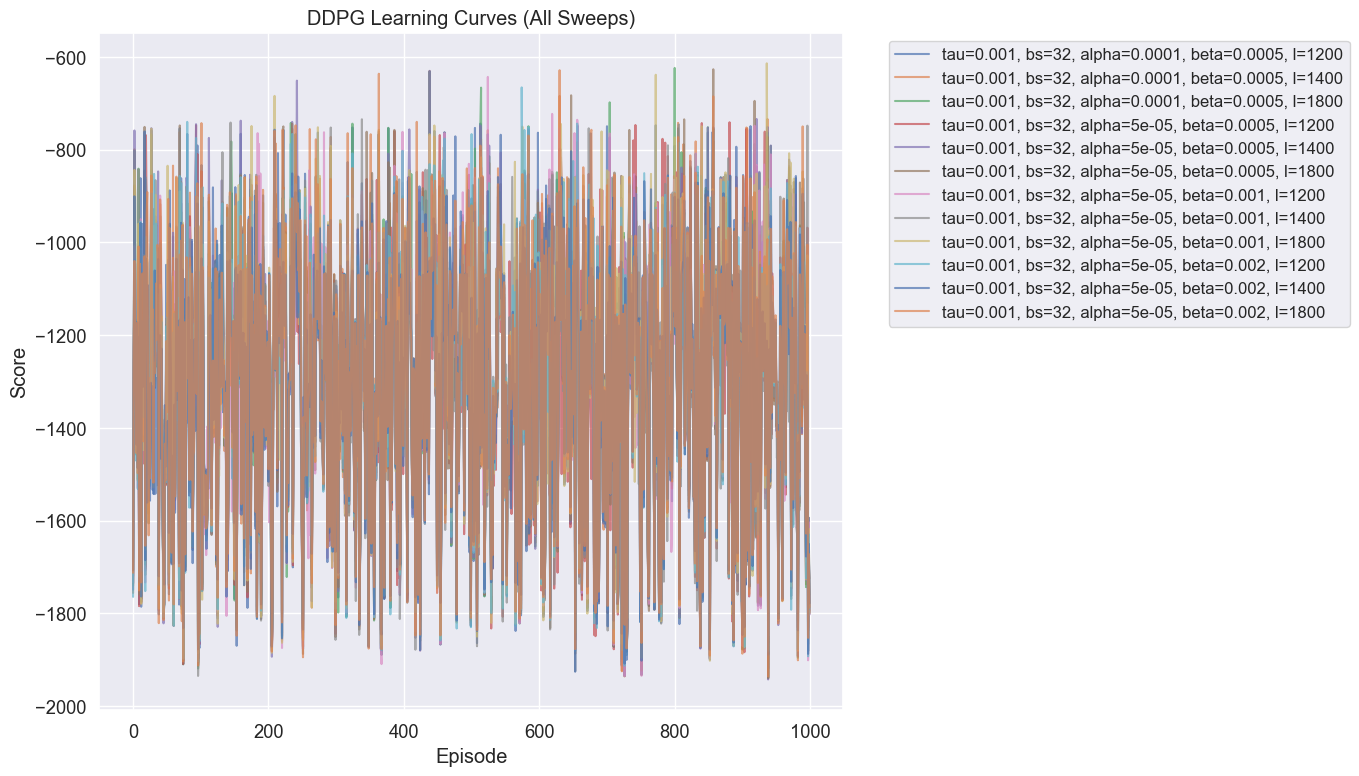

In [6]:
# 4. Plot All Learning Curves

plt.figure(figsize=(14, 8))
for i, row in results_df.iterrows():
    label = f"tau={row['tau']}, bs={row['batch_size']}, alpha={row['alpha']}, beta={row['beta']}, l={row['layers']}"
    plt.plot(row['scores'], label=label, alpha=0.7)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('DDPG Learning Curves (All Sweeps)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

In [8]:
# 5. Plot Critic/Actor Loss Curves (with diagnostics)

has_critic = 0
has_actor = 0
for i, row in results_df.iterrows():
    if isinstance(row.get('critic_losses'), (np.ndarray, list)) and len(row['critic_losses']) > 0:
        print(f"Run {i}: Critic loss shape: {np.shape(row['critic_losses'])}")
        has_critic += 1
    if isinstance(row.get('actor_losses'), (np.ndarray, list)) and len(row['actor_losses']) > 0:
        print(f"Run {i}: Actor loss shape: {np.shape(row['actor_losses'])}")
        has_actor += 1
if has_critic == 0 and has_actor == 0:
    print("No critic or actor loss data found in any run. Check if loss arrays are being saved during training.")
else:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    for i, row in results_df.iterrows():
        label = f"tau={row['tau']}, bs={row['batch_size']}, alpha={row['alpha']}, beta={row['beta']}, l={row['layers']}"
        if isinstance(row.get('critic_losses'), (np.ndarray, list)) and len(row['critic_losses']) > 0:
            axes[0].plot(row['critic_losses'], label=label, alpha=0.7)
        if isinstance(row.get('actor_losses'), (np.ndarray, list)) and len(row['actor_losses']) > 0:
            axes[1].plot(row['actor_losses'], label=label, alpha=0.7)
    axes[0].set_ylabel('Critic Loss')
    axes[0].set_title('Critic Loss Curves')
    axes[1].set_ylabel('Actor Loss')
    axes[1].set_title('Actor Loss Curves')
    axes[1].set_xlabel('Episode')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
    plt.tight_layout()
    plt.show()

No critic or actor loss data found in any run. Check if loss arrays are being saved during training.


# Advanced Analysis: Stability, Robustness, and Hyperparameter Insights

This section provides deeper insights into DDPG sweep results, including:
- Learning stability and variance across seeds
- Best, worst, and median runs per hyperparameter set
- Enhanced final performance tables
- Sample efficiency and convergence
- Hyperparameter heatmaps
- Aggregate metrics and outlier detection
- Correlation analysis

All code is modular and ready for extension or automated reporting.

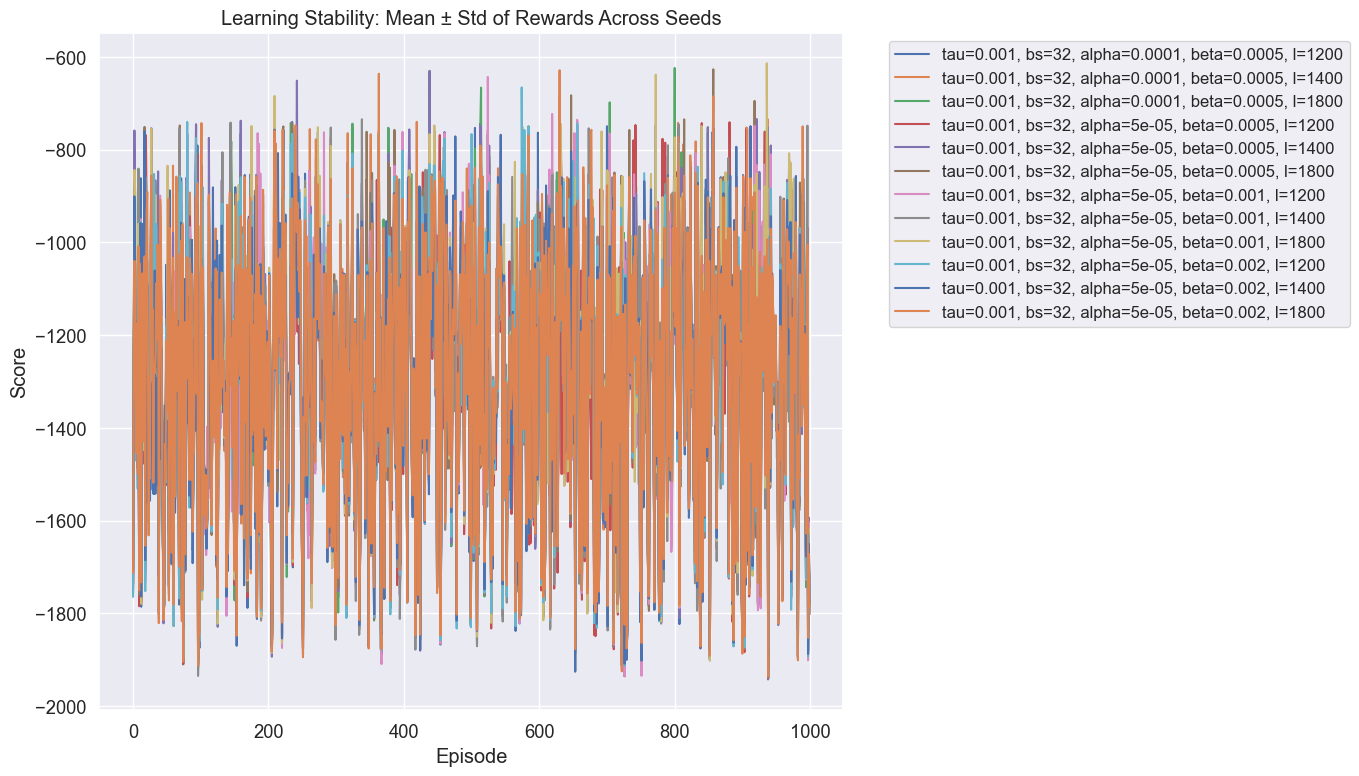

In [9]:
# 6. Learning Stability and Variance (Mean ± Std Across Seeds)

from collections import defaultdict

def get_hparam_key(row):
    return (row['tau'], row['batch_size'], row['alpha'], row['beta'], row['layers'])

# Group runs by hyperparameter set
hparam_groups = defaultdict(list)
for i, row in results_df.iterrows():
    key = get_hparam_key(row)
    hparam_groups[key].append(row['scores'])

plt.figure(figsize=(14, 8))
for key, score_list in hparam_groups.items():
    scores_matrix = np.stack([s for s in score_list if s is not None])
    mean_curve = np.mean(scores_matrix, axis=0)
    std_curve = np.std(scores_matrix, axis=0)
    label = f"tau={key[0]}, bs={key[1]}, alpha={key[2]}, beta={key[3]}, l={key[4]}"
    plt.plot(mean_curve, label=label)
    plt.fill_between(np.arange(len(mean_curve)), mean_curve-std_curve, mean_curve+std_curve, alpha=0.2)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Learning Stability: Mean ± Std of Rewards Across Seeds')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

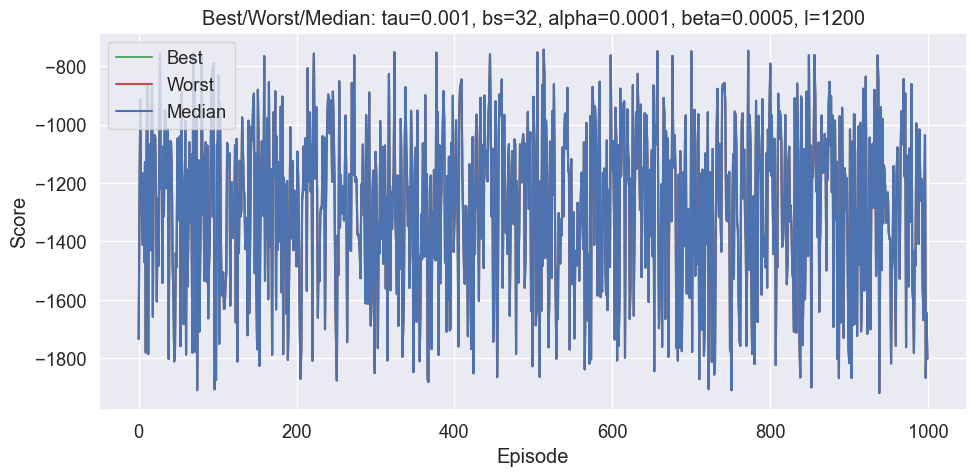

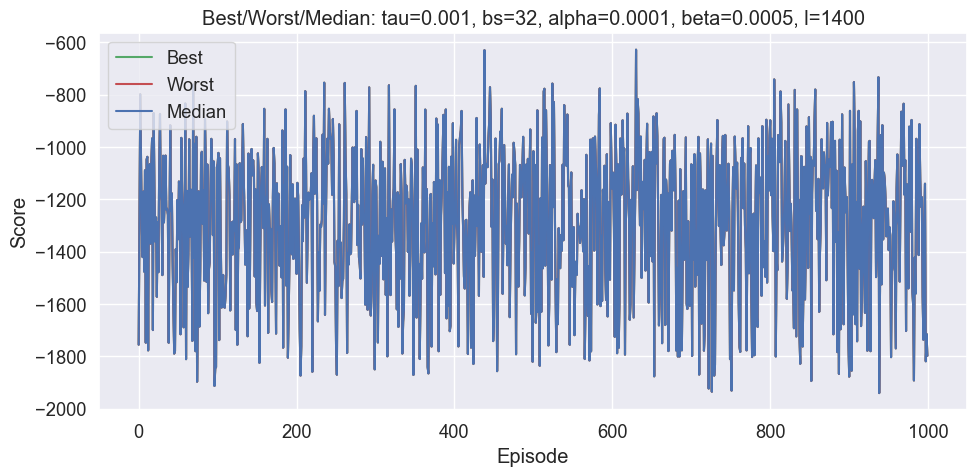

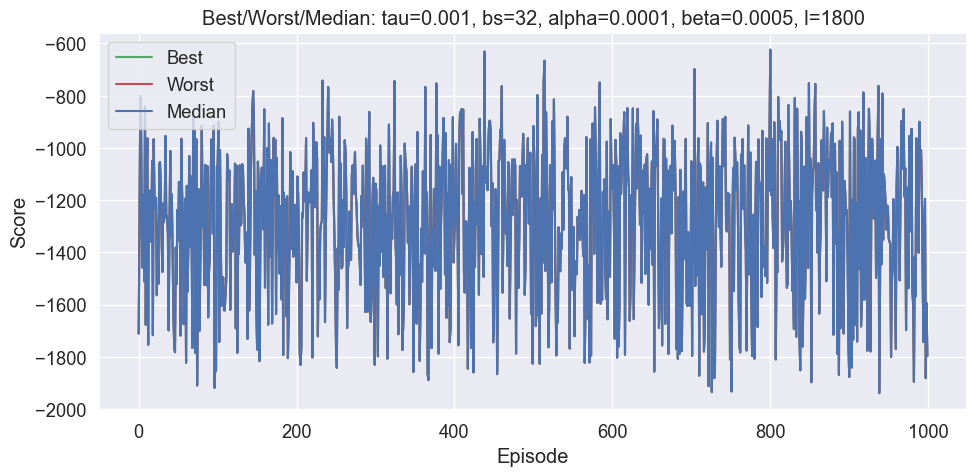

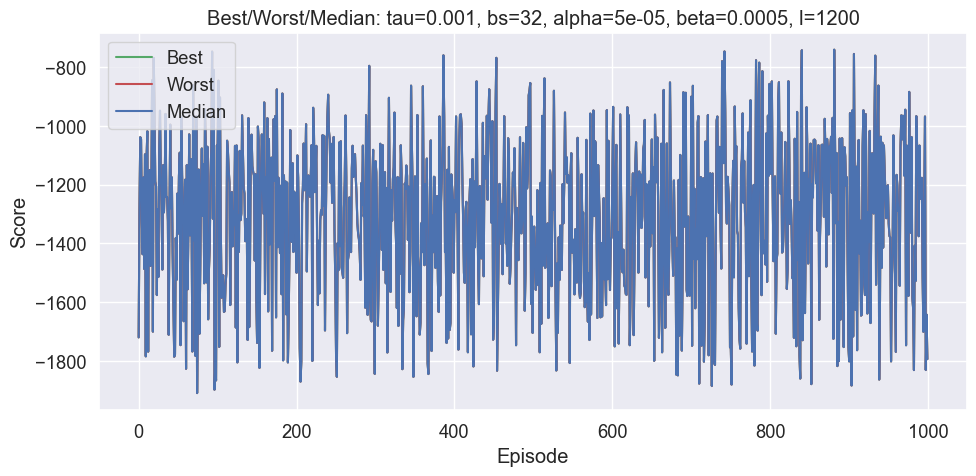

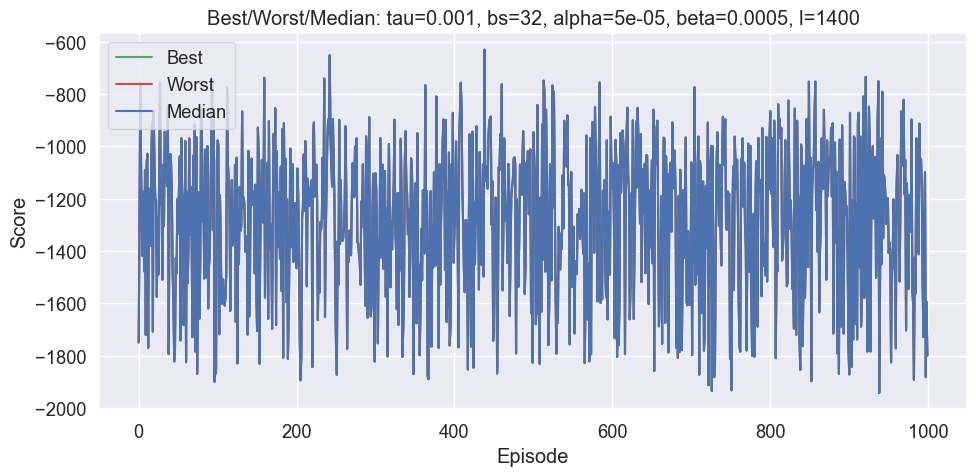

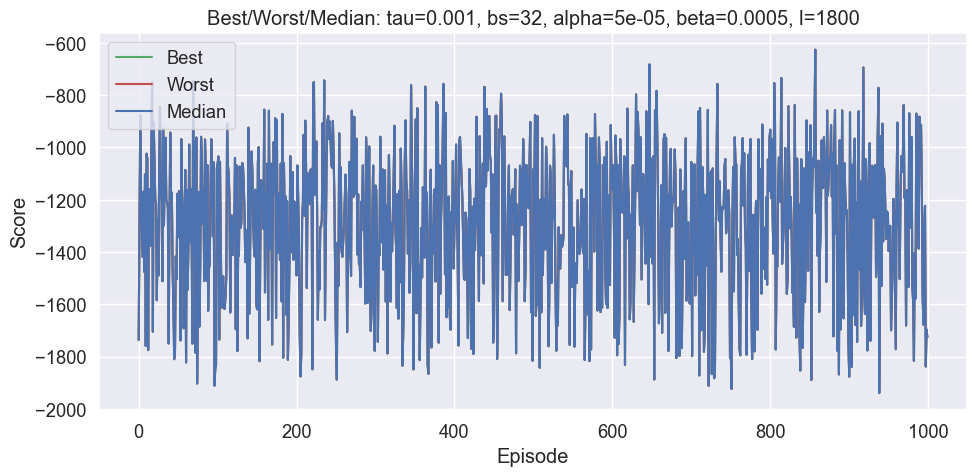

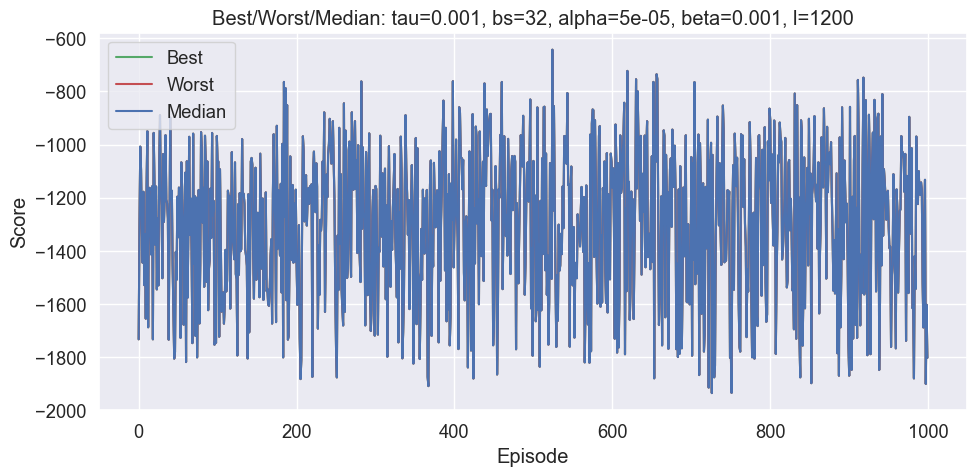

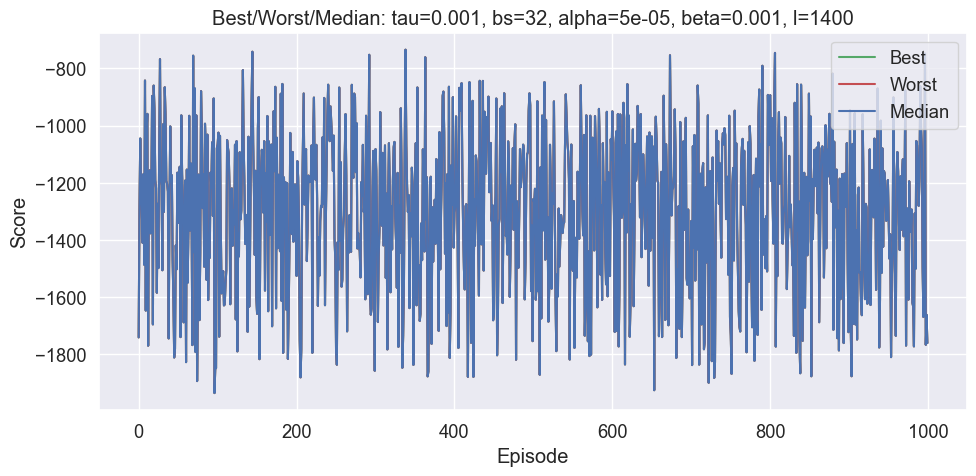

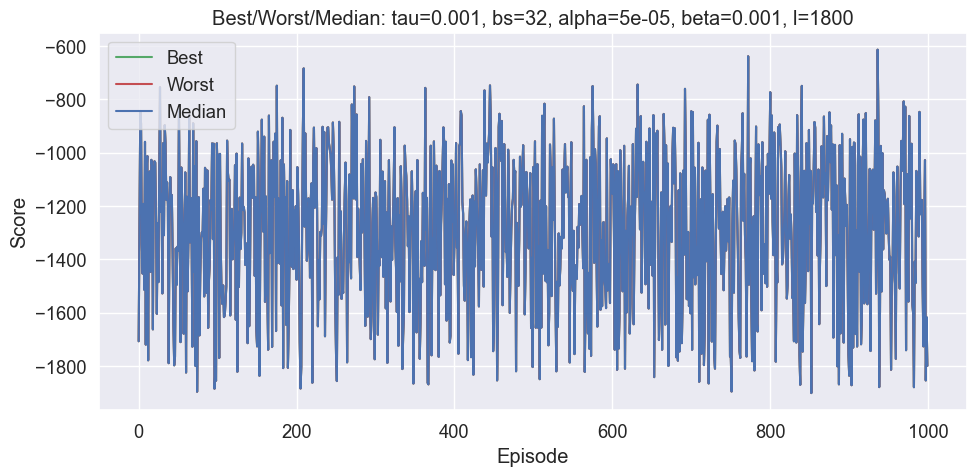

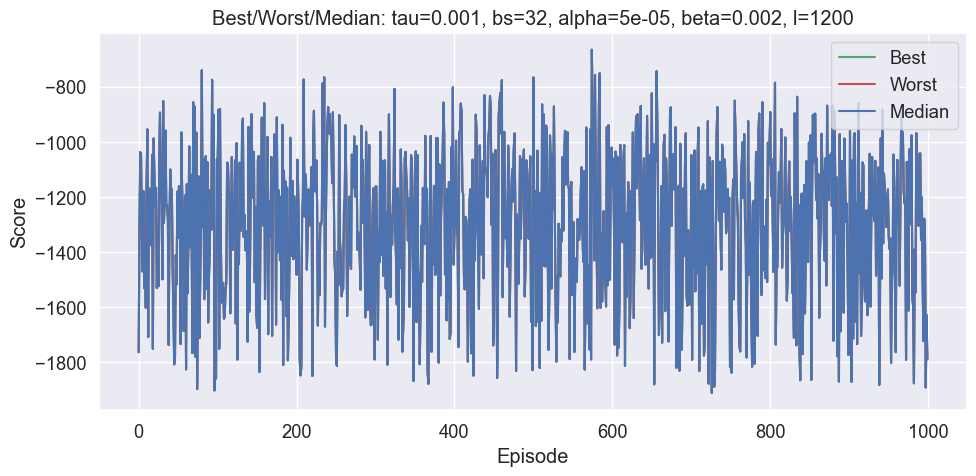

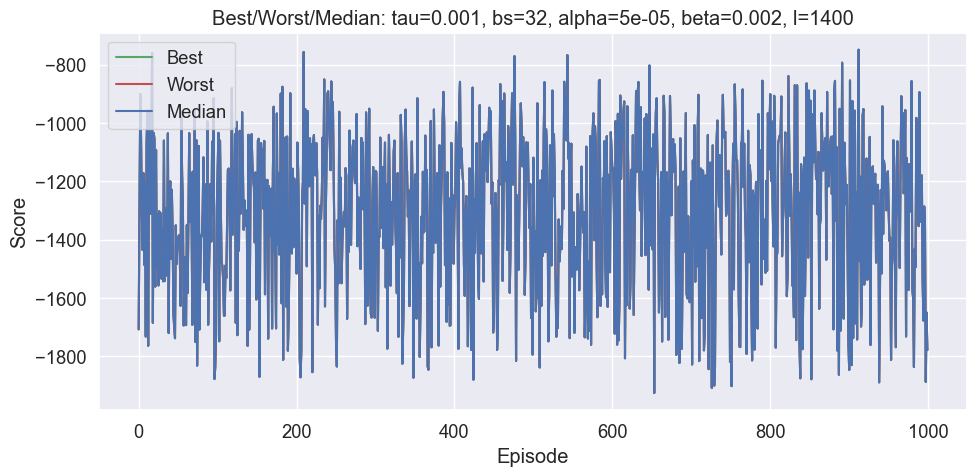

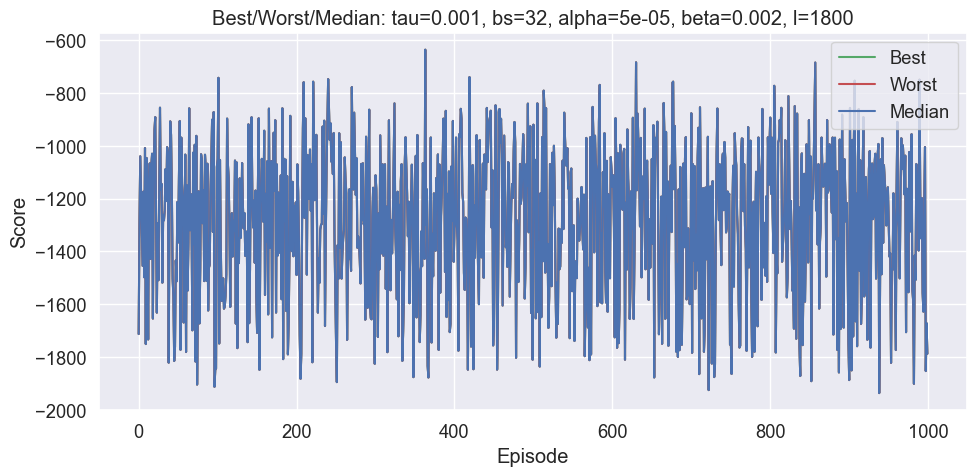

In [10]:
# 7. Best, Worst, and Median Runs per Hyperparameter Set

for key, score_list in hparam_groups.items():
    scores_matrix = np.stack([s for s in score_list if s is not None])
    final_scores = scores_matrix[:, -1]
    best_idx = np.argmax(final_scores)
    worst_idx = np.argmin(final_scores)
    median_idx = np.argsort(final_scores)[len(final_scores)//2]
    plt.figure(figsize=(10, 5))
    plt.plot(scores_matrix[best_idx], label='Best', color='g')
    plt.plot(scores_matrix[worst_idx], label='Worst', color='r')
    plt.plot(scores_matrix[median_idx], label='Median', color='b')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title(f'Best/Worst/Median: tau={key[0]}, bs={key[1]}, alpha={key[2]}, beta={key[3]}, l={key[4]}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [11]:
# 8. Enhanced Final Performance Table

def get_best_and_when(scores):
    best = np.max(scores)
    when = np.argmax(scores)
    return best, when

perf_table = []
for i, row in results_df.iterrows():
    best, when = get_best_and_when(row['scores'])
    perf_table.append({
        'tau': row['tau'],
        'batch_size': row['batch_size'],
        'alpha': row['alpha'],
        'beta': row['beta'],
        'layers': row['layers'],
        'mean_last100': np.mean(row['scores'][-100:]),
        'final_score': row['scores'][-1],
        'best_score': best,
        'best_episode': when,
        'timestamp': row['timestamp']
    })
perf_df = pd.DataFrame(perf_table)
display(perf_df.sort_values(by='mean_last100', ascending=False).reset_index(drop=True))

,tau,batch_size,alpha,beta,layers,mean_last100,final_score,best_score,best_episode,timestamp
0,0.001,32,0.00005,0.0005,1400,-1295.582066,-1799.067492,-630.004748,438,20250703
1,0.001,32,0.00010,0.0005,1800,-1296.724420,-1797.235671,-623.791215,800,20250704
2,0.001,32,0.00005,0.0010,1800,-1300.267646,-1799.861837,-613.831686,936,20250703
3,0.001,32,0.00005,0.0005,1800,-1301.676027,-1725.148885,-626.630256,857,20250703
4,0.001,32,0.00005,0.0010,1200,-1305.055320,-1802.753420,-643.160441,524,20250703
5,0.001,32,0.00010,0.0005,1400,-1308.157894,-1798.234453,-628.634918,630,20250704
6,0.001,32,0.00010,0.0005,1200,-1309.753053,-1802.117036,-743.767637,513,20250704
7,0.001,32,0.00005,0.0020,1800,-1310.358821,-1787.213450,-636.284963,363,20250704
8,0.001,32,0.00005,0.0005,1200,-1313.101839,-1793.950100,-740.844725,881,20250703
9,0.001,32,0.00005,0.0020,1200,-1330.681774,-1790.178782,-665.732617,574,20250703


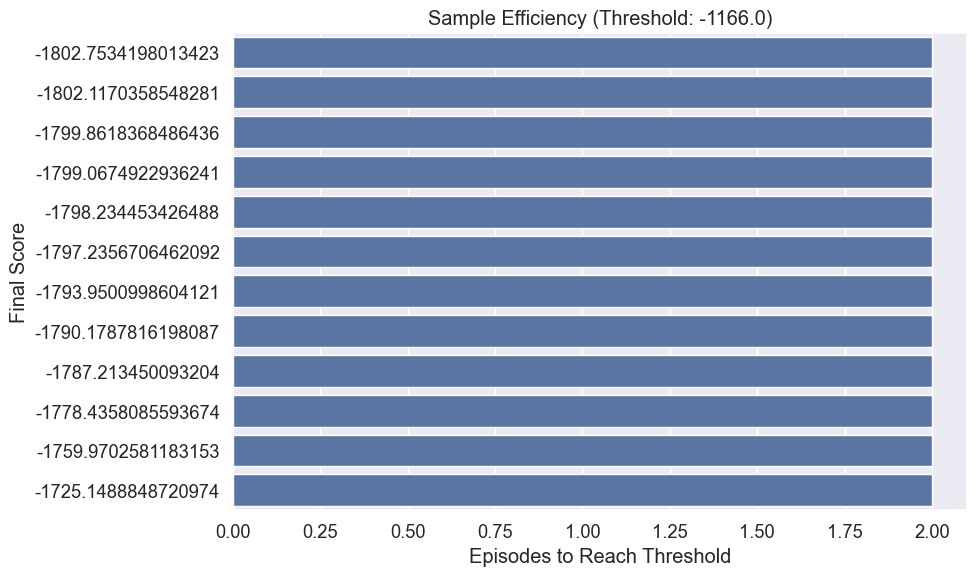

,tau,batch_size,alpha,beta,layers,episodes_to_threshold,final_score
0,0.001,32,0.00010,0.0005,1200,2,-1802.117036
1,0.001,32,0.00010,0.0005,1400,2,-1798.234453
2,0.001,32,0.00010,0.0005,1800,2,-1797.235671
3,0.001,32,0.00005,0.0005,1200,2,-1793.950100
4,0.001,32,0.00005,0.0005,1400,2,-1799.067492
5,0.001,32,0.00005,0.0005,1800,2,-1725.148885
6,0.001,32,0.00005,0.0010,1200,2,-1802.753420
7,0.001,32,0.00005,0.0010,1400,2,-1759.970258
8,0.001,32,0.00005,0.0010,1800,2,-1799.861837
9,0.001,32,0.00005,0.0020,1200,2,-1790.178782


In [12]:
# 9. Sample Efficiency: Episodes to Reach Reward Threshold

reward_threshold = perf_df['mean_last100'].max() * 0.9 if len(perf_df) > 0 else 200  # 90% of best mean or default
sample_eff = []
for i, row in results_df.iterrows():
    scores = row['scores']
    reached = np.where(scores >= reward_threshold)[0]
    first_ep = reached[0] if len(reached) > 0 else np.nan
    sample_eff.append({
        'tau': row['tau'],
        'batch_size': row['batch_size'],
        'alpha': row['alpha'],
        'beta': row['beta'],
        'layers': row['layers'],
        'episodes_to_threshold': first_ep,
        'final_score': row['scores'][-1]
    })
sample_eff_df = pd.DataFrame(sample_eff)
plt.figure(figsize=(10, 6))
sns.barplot(data=sample_eff_df, x='episodes_to_threshold', y='final_score', orient='h')
plt.xlabel('Episodes to Reach Threshold')
plt.ylabel('Final Score')
plt.title(f'Sample Efficiency (Threshold: {reward_threshold:.1f})')
plt.tight_layout()
plt.show()
display(sample_eff_df.sort_values('episodes_to_threshold'))

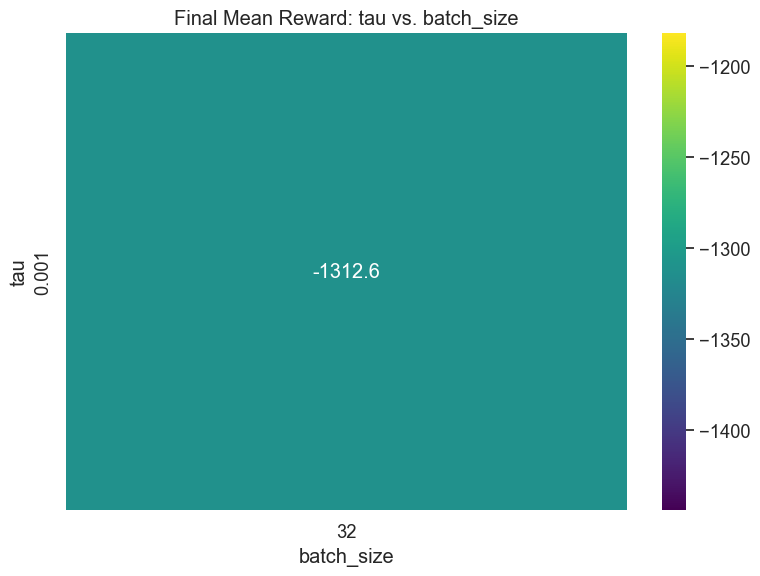

In [13]:
# 10. Hyperparameter Heatmaps (e.g., tau vs. batch_size)

if len(perf_df) > 0:
    heatmap_data = perf_df.pivot_table(index='tau', columns='batch_size', values='mean_last100', aggfunc='mean')
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='viridis')
    plt.title('Final Mean Reward: tau vs. batch_size')
    plt.ylabel('tau')
    plt.xlabel('batch_size')
    plt.tight_layout()
    plt.show()

In [14]:
# 11. Aggregate Metrics

avg_reward = perf_df['mean_last100'].mean() if len(perf_df) > 0 else np.nan
frac_above_thresh = (perf_df['mean_last100'] > reward_threshold).mean() if len(perf_df) > 0 else np.nan
avg_time_to_converge = sample_eff_df['episodes_to_threshold'].mean() if len(sample_eff_df) > 0 else np.nan
median_time_to_converge = sample_eff_df['episodes_to_threshold'].median() if len(sample_eff_df) > 0 else np.nan

print(f"Average final mean reward: {avg_reward:.2f}")
print(f"Fraction of runs above threshold: {frac_above_thresh:.2%}")
print(f"Average episodes to threshold: {avg_time_to_converge:.1f}")
print(f"Median episodes to threshold: {median_time_to_converge:.1f}")

Average final mean reward: -1312.62
Fraction of runs above threshold: 0.00%
Average episodes to threshold: 2.0
Median episodes to threshold: 2.0


In [15]:
# 12. Outlier Detection

if len(perf_df) > 0:
    q1 = perf_df['mean_last100'].quantile(0.25)
    q3 = perf_df['mean_last100'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = perf_df[(perf_df['mean_last100'] < lower) | (perf_df['mean_last100'] > upper)]
    print(f"Number of outlier runs: {len(outliers)}")
    display(outliers)
    if len(outliers) > 0:
        print("Possible causes: random seed, unstable hyperparameters, implementation bugs, or environment stochasticity.")

Number of outlier runs: 1


,tau,batch_size,alpha,beta,layers,mean_last100,final_score,best_score,best_episode,timestamp
7,0.001,32,0.00005,0.001,1400,-1347.006905,-1759.970258,-734.484263,338,20250703


Possible causes: random seed, unstable hyperparameters, implementation bugs, or environment stochasticity.


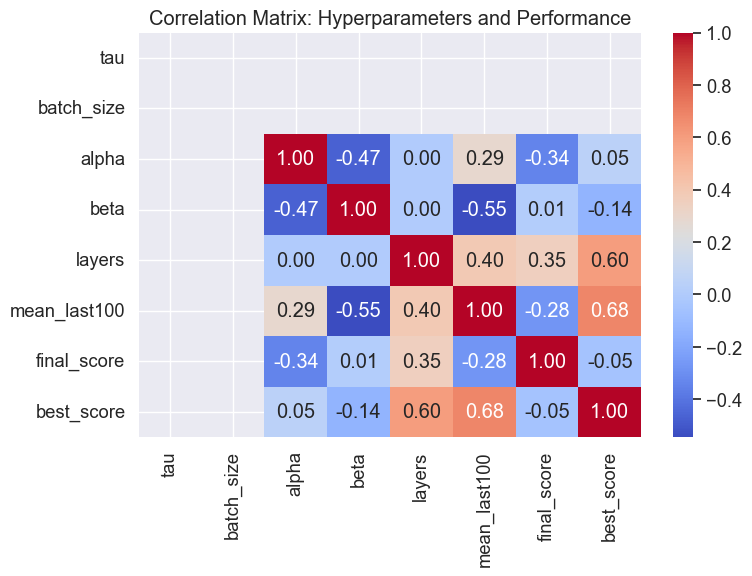

mean_last100    1.000000
best_score      0.683185
layers          0.395831
alpha           0.290861
final_score    -0.275580
beta           -0.545577
tau                  NaN
batch_size           NaN
Name: mean_last100, dtype: float64


In [16]:
# 13. Correlation Analysis: Hyperparameters vs. Final Performance

if len(perf_df) > 0:
    corr = perf_df[['tau', 'batch_size', 'alpha', 'beta', 'layers', 'mean_last100', 'final_score', 'best_score']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix: Hyperparameters and Performance')
    plt.tight_layout()
    plt.show()
    print(corr['mean_last100'].sort_values(ascending=False))

# 14. Automated Report Generation

To generate a professional report with all tables, plots, and summary statistics:

- Run all cells in this notebook.
- Export as PDF or HTML via `File > Export As` in VS Code or Jupyter Lab.
- Optionally, use `nbconvert` from the command line:

```bash
jupyter nbconvert --to html analyze_sweeps.ipynb
jupyter nbconvert --to pdf analyze_sweeps.ipynb
```

This ensures all analyses are reproducible and ready for sharing or publication.